# Multi agent non cooperative repeated experiment with mixed strategies and dynamic environment

In this setup, we will consider tasks being assigned to 4 agents:  
* 1 Requesters
* 1 dApp providers
* 1 Data providers
* 1 Computing providers

Every agent will have a randomly set ratio of failed task. This simulate more accurately real life scenario with:
* honest and experimented agents never triggering failed tasks.
* honest and beginer agents triggering by mistake a small ratio of failed tasks.
* malicious agents with mixed strategy triggering a fairly big amount of failed task.
* malicious agents with pure strategy always triggering failed tasks.

It takes only one faulty agent to fail the task.

We'll try implementing a staking system composed of two pools:  
* The stacking pool where a user initially deposit his funds.
* The slashing pool where a part of a user stake is deposited on each failed task he take parts in.

If an actor's stacking pool is empty after being slashed too many times, it is banned from the network and cannot take part in tasks anymore. The amount in the slashing pool is distributed among everyone who took part in a faulty transaction with that user.  

When taking part in a successful transaction, a small part of the slashing pool is restituted to the user as a reward.

## Basic functions

In [25]:
import math
import random
import matplotlib.pyplot as plt

In [26]:
# Constants
NUM_REQUESTERS = 100
NUM_DAPP_PROVIDERS = 100
NUM_DATA_PROVIDERS = 100
NUM_COMPUTING_PROVIDERS = 100
NUM_INTERESTING_AGENTS = 5
TOTAL_TASKS = 50000
STAKE_AMOUNT = 1000  # Amount needed to be staked in RLC

HONEST_RATIO = 0.8
MALICOUS_TRESHOLD = 0.05

SLASH_PERCENT_REQUESTER = 0.4
SLASH_PERCENT_DAPP_PROVIDER = 0.4
SLASH_PERCENT_DATA_PROVIDER = 0.4
SLASH_PERCENT_COMPUTING_PROVIDER = 0.4

REWARD_NUMBER_SLICE = 3 # Number of slices to divide the slash amount into
FAILED_TASK_BUCKET_SIZE = 1000  # Bucket size for failed tasks

REWARD_PERCENT_REQUESTER = 0.75
REWARD_PERCENT_DAPP_PROVIDER = 0.75
REWARD_PERCENT_DATA_PROVIDER = 0.75
REWARD_PERCENT_COMPUTING_PROVIDER = 0.75

In [27]:
def generate_failure_rate():
    u = random.uniform(0, 1)
    
    if u < HONEST_RATIO:
        # 80% of the time, return a low failure rate
        return random.uniform(0.0, MALICOUS_TRESHOLD)
    else:
        # 20% of the time, return a high failure rate
        return random.uniform(MALICOUS_TRESHOLD, 1.0)

# Define classes for agents
class Agent:
    def __init__(self, id, stake_pool):
        self.id = id
        self.stake_pool = stake_pool
        self.slash_pool = []
        self.failure_rate = generate_failure_rate()
        self.tasks_id = []

    def is_failing(self):
        return random.random() < self.failure_rate
    
    def is_malicious(self):
        return self.failure_rate > MALICOUS_TRESHOLD
    
    def initiate_task(self, requesters, dapp_providers, data_providers, computing_providers, tasks):
        # Check if pools are not empty
        if not requesters or not dapp_providers or not data_providers or not computing_providers:
            return False  # No task can be performed if any pool is empty

        if len(dapp_providers) < NUM_INTERESTING_AGENTS or len(data_providers) < NUM_INTERESTING_AGENTS or len(computing_providers) < NUM_INTERESTING_AGENTS:
            dapp_provider = random.choice(list(dapp_providers.values()))
            data_provider = random.choice(list(data_providers.values()))
            computing_provider = random.choice(list(computing_providers.values()))
        else:
            # Taking random providers considered as interesting for task
            interesting_dapp_providers = random.sample(list(dapp_providers.values()), NUM_INTERESTING_AGENTS)
            interesting_data_providers = random.sample(list(data_providers.values()), NUM_INTERESTING_AGENTS)
            interesting_computing_providers = random.sample(list(computing_providers.values()), NUM_INTERESTING_AGENTS)
            
            # Find the provider with the largest staking pool in each list
            dapp_provider = max(interesting_dapp_providers, key=lambda provider: provider.stake_pool)
            data_provider = max(interesting_data_providers, key=lambda provider: provider.stake_pool)
            computing_provider = max(interesting_computing_providers, key=lambda provider: provider.stake_pool)

        # Choose random costs (1 to 100 RLC)
        dapp_cost = random.randint(10, 100)
        data_cost = random.randint(10, 100)
        computing_cost = (dapp_cost + data_cost) // 2

        task = Task(len(tasks), self.id, dapp_provider.id, data_provider.id, computing_provider.id, dapp_cost, data_cost, computing_cost)
        tasks.append(task)
    
        return task.process(self, requesters, dapp_providers, data_providers, computing_providers)

    def print_info(self):
        return f"Agent ID: {self.id}, Stake Pool: {self.stake_pool}, Slash Pool: {self.stake_pool}, Failure Rate: {self.failure_rate}"
    
# Define classes for Tasks
class Task:
    def __init__(self, id, requester_id, dapp_provider_id, data_provider_id, computing_provider_id, dapp_cost, data_cost, computing_cost):
        self.id = id
        self.requester_id = requester_id
        self.dapp_provider_id = dapp_provider_id
        self.data_provider_id = data_provider_id
        self.computing_provider_id = computing_provider_id
        self.dapp_cost = dapp_cost
        self.data_cost = data_cost
        self.computing_cost = computing_cost
        self.success = False

    # Function to calculate quadratic slices
    def calculate_quadratic_slices(self, total_amount, n_slices):
        # Calculate the sum of squares of the first n natural numbers
        sum_of_squares = sum(i**2 for i in range(1, n_slices + 1))
        
        # Calculate each slice
        slices = [(total_amount * (i**2) / sum_of_squares) for i in range(1, n_slices + 1)]
        
        return slices

    def process(self, requester, requesters, dapp_providers, data_providers, computing_providers):
        # Fetching participants
        dapp_provider = dapp_providers[self.dapp_provider_id]
        data_provider = data_providers[self.data_provider_id]
        computing_provider = computing_providers[self.computing_provider_id]

        # Checking if any agent in the task group is malicious
        task_failed = any(agent.is_failing() for agent in [requester, dapp_provider, data_provider, computing_provider])

        if task_failed:
            self.success = False

            # Calculate slashing amounts
            # slash_amount_requester = SLASH_PERCENT_REQUESTER * self.computing_cost
            # slash_amount_dapp_provider = SLASH_PERCENT_DAPP_PROVIDER * self.computing_cost
            # slash_amount_data_provider = SLASH_PERCENT_DATA_PROVIDER * self.computing_cost
            # # Computing provider is not slashed but incurs the cost of computation as a penalty
            # slash_amount_computing_provider = SLASH_PERCENT_COMPUTING_PROVIDER * self.computing_cost
            slash_amount_requester = ( (STAKE_AMOUNT - requester.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_REQUESTER ) * self.computing_cost
            slash_amount_dapp_provider = ( (STAKE_AMOUNT - dapp_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_DAPP_PROVIDER ) * self.computing_cost
            slash_amount_data_provider = ( (STAKE_AMOUNT - data_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_DATA_PROVIDER ) * self.computing_cost
            # Computing provider is not slashed but incurs the cost of computation as a penalty
            slash_amount_computing_provider = ( (STAKE_AMOUNT - computing_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_COMPUTING_PROVIDER ) * self.computing_cost


            # Slash the agents
            # requester.stake_pool -=  slash_amount_requester
            # for _ in range(REWARD_NUMBER_SLICE):
            #     requester.slash_pool.append(slash_amount_requester / REWARD_NUMBER_SLICE)  
            # dapp_provider.stake_pool -= slash_amount_dapp_provider
            # for _ in range(REWARD_NUMBER_SLICE):
            #     dapp_provider.slash_pool.append(slash_amount_dapp_provider / REWARD_NUMBER_SLICE)
            # data_provider.stake_pool -= slash_amount_data_provider
            # for _ in range(REWARD_NUMBER_SLICE):
            #     data_provider.slash_pool.append(slash_amount_data_provider / REWARD_NUMBER_SLICE)
            # computing_provider.stake_pool -= slash_amount_computing_provider
            # for _ in range(REWARD_NUMBER_SLICE):
            #     computing_provider.slash_pool.append(slash_amount_computing_provider / REWARD_NUMBER_SLICE)
            requester.stake_pool -= slash_amount_requester
            dapp_provider.stake_pool -= slash_amount_dapp_provider
            data_provider.stake_pool -= slash_amount_data_provider
            computing_provider.stake_pool -= slash_amount_computing_provider

            # Calculate quadratic slices
            requester_slices = self.calculate_quadratic_slices(slash_amount_requester, REWARD_NUMBER_SLICE)
            dapp_provider_slices = self.calculate_quadratic_slices(slash_amount_dapp_provider, REWARD_NUMBER_SLICE)
            data_provider_slices = self.calculate_quadratic_slices(slash_amount_data_provider, REWARD_NUMBER_SLICE)
            computing_provider_slices = self.calculate_quadratic_slices(slash_amount_computing_provider, REWARD_NUMBER_SLICE)

            # Append slices to slash pools
            requester.slash_pool.extend(requester_slices)
            dapp_provider.slash_pool.extend(dapp_provider_slices)
            data_provider.slash_pool.extend(data_provider_slices)
            computing_provider.slash_pool.extend(computing_provider_slices)


            # Check if any agent's stake pool is empty
            if requester.stake_pool <= 0:
                print(f"BANNED REQUESTER: {requester.print_info()}")
                del requesters[requester.id]
            if dapp_provider.stake_pool <= 0:
                print(f"BANNED DAPP PROVIDER: {dapp_provider.print_info()}")
                del dapp_providers[dapp_provider.id]
            if data_provider.stake_pool <= 0:
                print(f"BANNED DATA PROVIDER: {data_provider.print_info()}")
                del data_providers[data_provider.id]
            if computing_provider.stake_pool <= 0:
                print(f"BANNED COMPUTING PROVIDER: {computing_provider.print_info()}")
                del computing_providers[computing_provider.id]
        
        else:
            self.success = True

            if len(requester.slash_pool) > 0:
                # reward_amount_requester = ( requester.stake_pool * REWARD_PERCENT_REQUESTER ) / STAKE_AMOUNT * requester.slash_pool[0]
                reward_amount_requester = requester.slash_pool[0]

                requester.stake_pool +=  reward_amount_requester

                # requester.slash_pool.append(requester.slash_pool[0] - reward_amount_requester)
                requester.slash_pool.pop(0)

            if len(dapp_provider.slash_pool) > 0:
                # reward_amount_dapp_provider = ( dapp_provider.stake_pool * REWARD_PERCENT_DAPP_PROVIDER ) / STAKE_AMOUNT * dapp_provider.slash_pool[0]
                reward_amount_dapp_provider = dapp_provider.slash_pool[0]

                dapp_provider.stake_pool += reward_amount_dapp_provider

                # dapp_provider.slash_pool.append(dapp_provider.slash_pool[0] - reward_amount_dapp_provider)
                dapp_provider.slash_pool.pop(0)

            if len(data_provider.slash_pool) > 0:
                # reward_amount_data_provider = ( data_provider.stake_pool * REWARD_PERCENT_DATA_PROVIDER ) / STAKE_AMOUNT * data_provider.slash_pool[0]
                reward_amount_data_provider = data_provider.slash_pool[0]

                data_provider.stake_pool += reward_amount_data_provider

                # data_provider.slash_pool.append(data_provider.slash_pool[0] - reward_amount_data_provider)
                data_provider.slash_pool.pop(0)

            if len(computing_provider.slash_pool) > 0:
                # # Not really possible for computing provider, to be improved
                # reward_amount_computing_provider = ( computing_provider.stake_pool * REWARD_PERCENT_COMPUTING_PROVIDER ) / STAKE_AMOUNT * computing_provider.slash_pool[0]
                reward_amount_computing_provider = computing_provider.slash_pool[0]

                computing_provider.stake_pool += reward_amount_computing_provider

                # computing_provider.slash_pool.append(computing_provider.slash_pool[0] - reward_amount_computing_provider)
                computing_provider.slash_pool.pop(0)
            

        # Return the result of the task (success or failure)
        return not task_failed

    def print_info(self):
        return f"Transaction ID: {self.id}, Request ID: {self.requester_id}, dApp Provider ID: {self.dapp_provider_id}, Data Provider ID: {self.data_provider_id}, Computing Provider ID: {self.computing_provider_id}"

Total tasks: 50000
Successful tasks: 48708
Failed tasks: 1292
Remaining agents:
Requesters: 100
dApp Providers: 100
Data Providers: 100
Computing Providers: 100

Remaining Malicious Agents:
Malicious Requesters:
Agent ID: 12, Stake Pool: 925.0288139428571, Slash Pool: 925.0288139428571, Failure Rate: 0.38284797068390414
Agent ID: 13, Stake Pool: 937.7910191689143, Slash Pool: 937.7910191689143, Failure Rate: 0.6653731336826745
Agent ID: 20, Stake Pool: 929.4197948000001, Slash Pool: 929.4197948000001, Failure Rate: 0.7132997936733826
Agent ID: 26, Stake Pool: 915.2010982857142, Slash Pool: 915.2010982857142, Failure Rate: 0.45122050608145264
Agent ID: 31, Stake Pool: 943.3352000000004, Slash Pool: 943.3352000000004, Failure Rate: 0.10532138183731087
Agent ID: 35, Stake Pool: 938.096481872, Slash Pool: 938.096481872, Failure Rate: 0.8180976243843043
Agent ID: 66, Stake Pool: 952.5818955233876, Slash Pool: 952.5818955233876, Failure Rate: 0.34096727688492756
Agent ID: 71, Stake Pool: 946

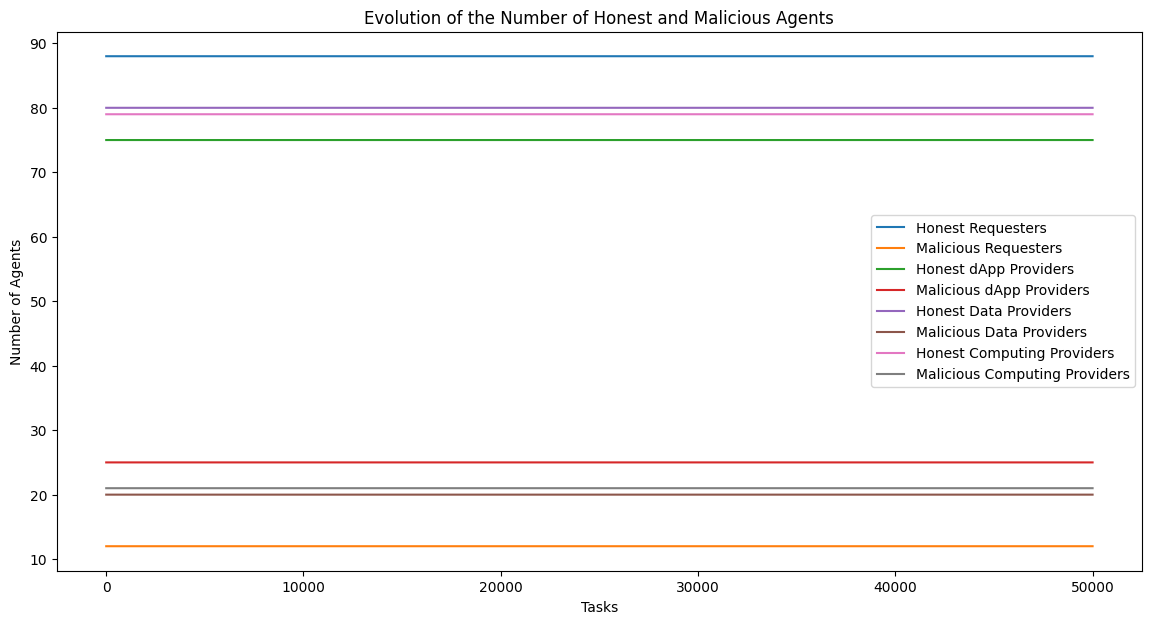

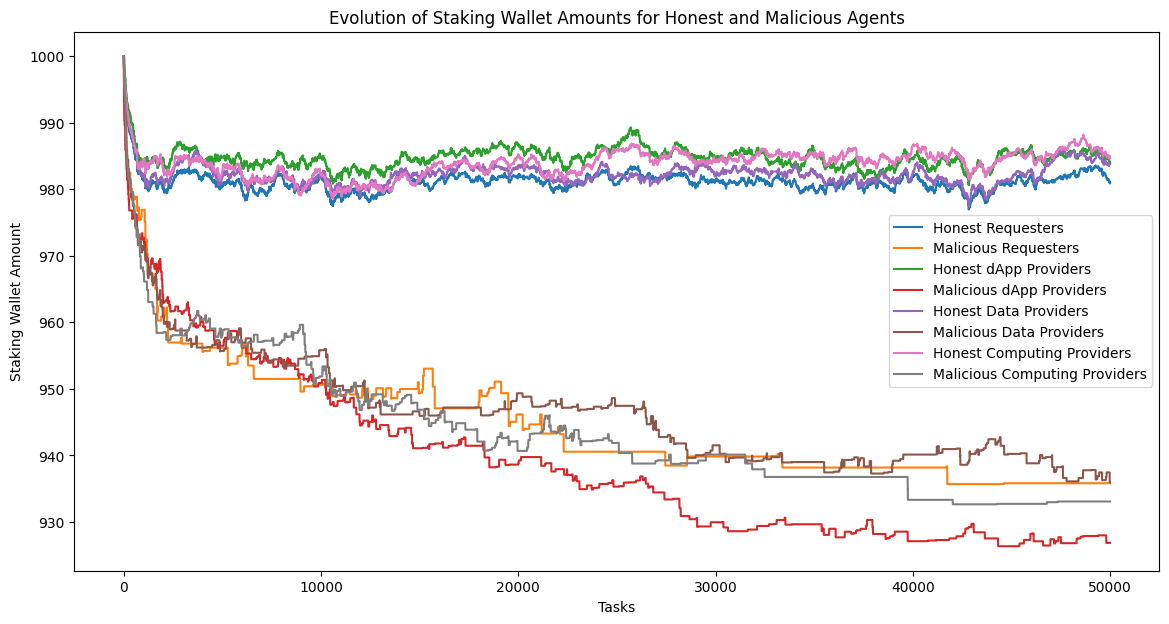

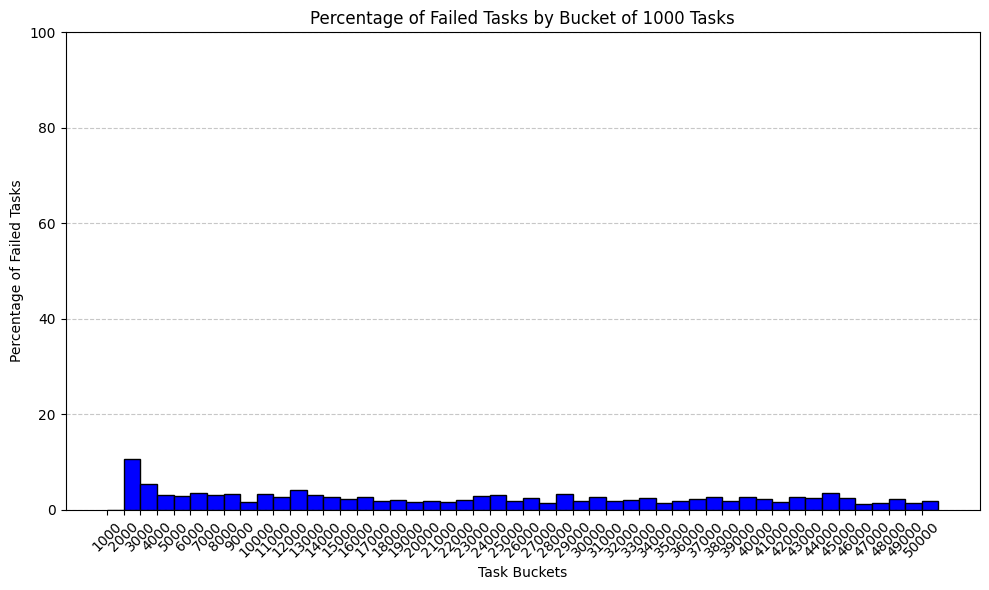

In [28]:
# Initialize pools of agents
requesters = {i: Agent(i, STAKE_AMOUNT) for i in range(NUM_REQUESTERS)}
dapp_providers = {i: Agent(i, STAKE_AMOUNT) for i in range(NUM_DAPP_PROVIDERS)}
data_providers = {i: Agent(i, STAKE_AMOUNT) for i in range(NUM_DATA_PROVIDERS)}
computing_providers = {i: Agent(i, STAKE_AMOUNT) for i in range(NUM_COMPUTING_PROVIDERS)}

# Initialize pool of transactions
tasks = []

# Lists to track the number of agents and their staking wallet amounts
honest_requester_counts = []
malicious_requester_counts = []
honest_dapp_provider_counts = []
malicious_dapp_provider_counts = []
honest_data_provider_counts = []
malicious_data_provider_counts = []
honest_computing_provider_counts = []
malicious_computing_provider_counts = []

honest_requester_wallets = []
malicious_requester_wallets = []
honest_dapp_provider_wallets = []
malicious_dapp_provider_wallets = []
honest_data_provider_wallets = []
malicious_data_provider_wallets = []
honest_computing_provider_wallets = []
malicious_computing_provider_wallets = []

# Simulate tasks
successful_tasks = 0
failed_tasks = 0
failed_tasks_count = []

for task_id in range(TOTAL_TASKS):
    # Track the number of agents
    honest_requester_counts.append(sum(1 for agent in requesters.values() if not agent.is_malicious()))
    malicious_requester_counts.append(sum(1 for agent in requesters.values() if agent.is_malicious()))
    honest_dapp_provider_counts.append(sum(1 for agent in dapp_providers.values() if not agent.is_malicious()))
    malicious_dapp_provider_counts.append(sum(1 for agent in dapp_providers.values() if agent.is_malicious()))
    honest_data_provider_counts.append(sum(1 for agent in data_providers.values() if not agent.is_malicious()))
    malicious_data_provider_counts.append(sum(1 for agent in data_providers.values() if agent.is_malicious()))
    honest_computing_provider_counts.append(sum(1 for agent in computing_providers.values() if not agent.is_malicious()))
    malicious_computing_provider_counts.append(sum(1 for agent in computing_providers.values() if agent.is_malicious()))

    # Track the total staking wallet amounts
    honest_requester_wallets.append(sum(agent.stake_pool for agent in requesters.values() if not agent.is_malicious()) / honest_requester_counts[-1] if honest_requester_counts[-1] != 0 else 0)
    malicious_requester_wallets.append(sum(agent.stake_pool for agent in requesters.values() if agent.is_malicious()) / malicious_requester_counts[-1] if malicious_requester_counts[-1] != 0 else 0)
    honest_dapp_provider_wallets.append(sum(agent.stake_pool for agent in dapp_providers.values() if not agent.is_malicious()) / honest_dapp_provider_counts[-1] if honest_dapp_provider_counts[-1] != 0 else 0)
    malicious_dapp_provider_wallets.append(sum(agent.stake_pool for agent in dapp_providers.values() if agent.is_malicious()) / malicious_dapp_provider_counts[-1] if malicious_dapp_provider_counts[-1] != 0 else 0)
    honest_data_provider_wallets.append(sum(agent.stake_pool for agent in data_providers.values() if not agent.is_malicious()) / honest_data_provider_counts[-1] if honest_data_provider_counts[-1] != 0 else 0)
    malicious_data_provider_wallets.append(sum(agent.stake_pool for agent in data_providers.values() if agent.is_malicious()) / malicious_data_provider_counts[-1] if malicious_data_provider_counts[-1] != 0 else 0)
    honest_computing_provider_wallets.append(sum(agent.stake_pool for agent in computing_providers.values() if not agent.is_malicious()) / honest_computing_provider_counts[-1] if honest_computing_provider_counts[-1] != 0 else 0)
    malicious_computing_provider_wallets.append(sum(agent.stake_pool for agent in computing_providers.values() if agent.is_malicious()) / malicious_computing_provider_counts[-1] if malicious_computing_provider_counts[-1] != 0 else 0)



    # Check if there are requesters left
    if requesters:
        requester = random.choice(list(requesters.values()))
        if len(requesters) < NUM_INTERESTING_AGENTS:
            requester = random.choice(list(requesters.values()))
        else:
            # Taking random providers considered as interesting for task
            interesting_requesters = random.sample(list(requesters.values()), NUM_INTERESTING_AGENTS)
            
            # Find the provider with the largest staking pool in each list
            requester = max(interesting_requesters, key=lambda requester: requester.stake_pool)


        task_succeded = requester.initiate_task(requesters, dapp_providers, data_providers, computing_providers, tasks)
        
        if task_succeded:
            successful_tasks += 1
        else:
            failed_tasks += 1

        if task_id % FAILED_TASK_BUCKET_SIZE == 0:
            failed_tasks_count.append(failed_tasks / FAILED_TASK_BUCKET_SIZE * 100)
            failed_tasks = 0

# Print results
print(f"Total tasks: {TOTAL_TASKS}")
print(f"Successful tasks: {successful_tasks}")
print(f"Failed tasks: {TOTAL_TASKS - successful_tasks}")

print("Remaining agents:")
print(f"Requesters: {len(requesters)}")
print(f"dApp Providers: {len(dapp_providers)}")
print(f"Data Providers: {len(data_providers)}")
print(f"Computing Providers: {len(computing_providers)}")

# Print remaining malicious agents
print("\nRemaining Malicious Agents:")
print("Malicious Requesters:")
for agent in requesters.values():
    if agent.is_malicious():
        print(agent.print_info())

print("\nMalicious dApp Providers:")
for agent in dapp_providers.values():
    if agent.is_malicious():
        print(agent.print_info())

print("\nMalicious Data Providers:")
for agent in data_providers.values():
    if agent.is_malicious():
        print(agent.print_info())

print("\nMalicious Computing Providers:")
for agent in computing_providers.values():
    if agent.is_malicious():
        print(agent.print_info())

# Plot the evolution of the number of each kind of agent
plt.figure(figsize=(14, 7))
plt.plot(honest_requester_counts, label='Honest Requesters')
plt.plot(malicious_requester_counts, label='Malicious Requesters')
plt.plot(honest_dapp_provider_counts, label='Honest dApp Providers')
plt.plot(malicious_dapp_provider_counts, label='Malicious dApp Providers')
plt.plot(honest_data_provider_counts, label='Honest Data Providers')
plt.plot(malicious_data_provider_counts, label='Malicious Data Providers')
plt.plot(honest_computing_provider_counts, label='Honest Computing Providers')
plt.plot(malicious_computing_provider_counts, label='Malicious Computing Providers')
plt.xlabel('Tasks')
plt.ylabel('Number of Agents')
plt.legend()
plt.title('Evolution of the Number of Honest and Malicious Agents')
plt.show()

# Plot the evolution of the staking wallet amounts
plt.figure(figsize=(14, 7))
plt.plot(honest_requester_wallets, label='Honest Requesters')
plt.plot(malicious_requester_wallets, label='Malicious Requesters')
plt.plot(honest_dapp_provider_wallets, label='Honest dApp Providers')
plt.plot(malicious_dapp_provider_wallets, label='Malicious dApp Providers')
plt.plot(honest_data_provider_wallets, label='Honest Data Providers')
plt.plot(malicious_data_provider_wallets, label='Malicious Data Providers')
plt.plot(honest_computing_provider_wallets, label='Honest Computing Providers')
plt.plot(malicious_computing_provider_wallets, label='Malicious Computing Providers')
plt.xlabel('Tasks')
plt.ylabel('Staking Wallet Amount')
plt.legend()
plt.title('Evolution of Staking Wallet Amounts for Honest and Malicious Agents')
plt.show()

# Plotting the failed tasks count as a bar graph in percentages
buckets = range(FAILED_TASK_BUCKET_SIZE, TOTAL_TASKS + FAILED_TASK_BUCKET_SIZE, FAILED_TASK_BUCKET_SIZE)
plt.figure(figsize=(10, 6))
plt.bar(buckets, failed_tasks_count, width=FAILED_TASK_BUCKET_SIZE, align='edge', color='b', edgecolor='black')
plt.title('Percentage of Failed Tasks by Bucket of 1000 Tasks')
plt.xlabel('Task Buckets')
plt.ylabel('Percentage of Failed Tasks')
plt.xticks(buckets, rotation=45)
plt.ylim(0, 100)  # Set y-axis limit to 0-100%
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

When picking the best out of N agents for the task, we end up in a system where noone is ever kicked.  
The wallets are slashed and we very quickly are able to tell the difference between honest and dishonest agent so that we only sollicitate honest one.  
However we still have a failure rate of around 20% of task.  
This need to be studied further with the multi armed bandit problem: do we explore random transaction to kick malicious consumer or do we stick to proven honest ones to achieve task successfuly.